# T028 · Kinase similarity: Compare different perspectives

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Talia B. Kimber, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Dominique Sydow, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Andrea Volkamer, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)

## Aim of this talktorial

We will compare different perspectives on kinase similarity, which were discussed in detail in previous notebooks:

* **Talktorial T024**: Kinase pocket sequences (KLIFS pocket sequences)
* **Talktorial T025**: Kinase pocket structures (KiSSim fingerprint based on KLIFS pocket residues)
* **Talktorial T026**: Kinase-ligand interaction profiles (KLIFS IFPs based on KLIFS pocket residues)
* **Talktorial T027**: Ligand profiling data (using ChEMBL29 bioactivity data)

_Note_: We focus only on similarities between orthosteric kinase binding sites; similarities to allosteric binding sites are not covered (T027 is an exception since the profiling data does not distinguish between binding sites).

### Contents in *Theory*

* Kinase dataset
* Kinase similarity descriptor (considering 4 different methods)
* Distance matrix conditions

### Contents in *Practical*

* Load kinase similarity and distance matrices
* Distance matrix conditions
* Visualize similarity for example perspective
  * Visualize kinase similarity matrix as heatmap
  * Visualize similarity as dendrogram
* Visualize similarities from the four different perspectives
  * Preprocess distance matrices
    * Normalize matrices
    * Define kinase order
  * Visualize kinase similarities
  * Analysis of results

### References

* Kinase dataset: [<i>Molecules</i> (2021), <b>26(3)</b>, 629](https://www.mdpi.com/1420-3049/26/3/629) 
* Clustering and dendrograms with `scipy`: https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html
* Distance matrix:
    * https://en.wikipedia.org/wiki/Distance_matrix
    * Gilbert, A. C. and Jain, L. "If it ain't broke, don't fix it: Sparse metric repair." _2017 55th Annual Allerton Conference on Communication, Control, and Computing (Allerton)_. IEEE, 2017. https://arxiv.org/pdf/1710.10655.pdf

## Theory

### Kinase dataset

We use the kinase selection as defined in __Talktorial T023__.

### Kinase similarity descriptor (considering 4 different methods)

- __Talktorial T024__ = KLIFS pocket sequence
- __Talktorial T025__ = KiSSim fingerprint
- __Talktorial T026__ = KLIFS interaction fingerprint
- __Talktorial T027__ = Ligand profile: ChEMBL29, bioactivity

Please refer to the talktorials for more details on each method.

### Distance matrix conditions

A square, real matrix $M \in \mathbb{R}^{n \times n}$ is a distance matrix if $M$ satisfies the following conditions (following the definition of distance) :

1. a. Positivity: $M[x, y] \geq 0$ for all $x, y$ and b. Null condition: $M[x, y] = 0 \iff x = y.$   
2. Symmetry: $M[x, y] = M[y, x]$ for all $x, y.$
3. Triangular inequality: $M[x, z] \leq M[x, y] + M[y, z]$ for all $x, y, z.$

_Technical note_: In some cases, the null condition can be relaxed and only the following has to be satisfied: $M[x, x] = 0, \forall x.$ In this case, the term is known as semi-metric. We will use this condition in this notebook.

## Practical

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance_matrix, distance
from scipy.cluster import hierarchy

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Load kinase similarity and distance matrices

We define the paths to the kinase distance matrices.

In [3]:
kinase_matrix_paths = {
    "sequence": "T024_kinase_similarity_sequence",
    "kissim": "T025_kinase_similarity_kissim",
    "ifp": "T026_kinase_similarity_ifp",
    "ligand-profile": "T027_kinase_similarity_ligand_profile",
}

# Distance matrices (for dendrogram)
kinase_distance_matrix_paths = {
    perspective: HERE / f"../{folder_name}/data/kinase_distance_matrix.csv"
    for perspective, folder_name in kinase_matrix_paths.items()
}

We load the distance matrices which were generated in the previous notebooks.

In [4]:
kinase_distance_matrices = {}
for kinsim_perspective, path in kinase_distance_matrix_paths.items():
    kinase_distance_matrices[kinsim_perspective] = pd.read_csv(path, index_col=0).round(6)

### Distance matrix conditions

We now create functions to verify the distance conditions.

We check the dimension of the matrix: it should be a 2D, square array.

In [5]:
def check_dimensionality(matrix):
    """
    Checks whether the input is a 2D array (matrix) and square.

    Parameters
    ----------
    matrix : np.array
        The matrix for which the condition should be checked.

    Returns
    -------
    bool :
        True if the condition is met, False otherwise.
    """
    if len(matrix.shape) != 2:
        raise ValueError(f"The input is not a matrix, but an array of shape {matrix.shape}.")
    elif matrix.shape[0] != matrix.shape[1]:
        raise ValueError(f"The input is not a square matrix. Failing.")
    else:
        return True

We check that all values of the matrix are positive.

In [6]:
def check_positivity(matrix):
    """
    Checks whether all values of a matrix are positive.

    Parameters
    ----------
    matrix : np.array
        The matrix for which the condition should be checked.

    Returns
    -------
    bool :
        True if the condition is met, False otherwise.
    """
    return (matrix >= 0).all()

We check that the diagonal values of the matrix are zero.

In [7]:
def check_null_diagonal(matrix):
    """
    Checks whether the diagonal entries of a matrix are all zero.

    Parameters
    ----------
    matrix : np.array
        The matrix for which the condition should be checked.

    Returns
    -------
    bool :
        True if the condition is met, False otherwise.
    """
    return (np.diagonal(matrix) == 0).all()

We check that the matrix is symmetric.

In [8]:
def check_symmetry(matrix):
    """
    Checks whether a matrix M is symmetric, i.e. M = M^T.

    Parameters
    ----------
    matrix : np.array
        The matrix for which the condition should be checked.

    Returns
    -------
    bool :
        True if the condition is met, False otherwise.
    """
    return (matrix == matrix.transpose()).all()

Finally, we check the triangular inequality condition.

In [9]:
def check_triangular_inequality(matrix, tolerance=0.11):
    """
    Checks whether the triangular inequality is met for a matrix,
    i.e. the shortest distance between two points is the straight line.

    Parameters
    ----------
    matrix : np.array
        The matrix for which the condition should be checked.
    tolerance : float
        The accepted tolerance for approximation.

    Returns
    -------
    bool :
        True if the condition is met, False otherwise.
    """
    triang_inequality = None
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[0]):
            for k in range(matrix.shape[0]):
                if matrix[i, j] <= matrix[i, k] + matrix[k, j] + tolerance:
                    triang_inequality = True
                else:
                    return False
    return triang_inequality

We now create a function that combines all these conditions.

In [10]:
def distance_condition(matrix):
    """
    Checks if all conditions for a matrix are met.

    Parameters
    ----------
    matrix : np.array
        The matrix for which the conditions should be checked.

    Returns
    -------
    None
    """

    dimensionality = check_dimensionality(matrix)
    if dimensionality:
        print(f"{'Dimensionality' : <30}" f"{'Satisfied'}")
    else:
        print(f"{'Dimensionality' : <30}" f"{'Not Satisfied'}")

    positivity = check_positivity(matrix)
    if positivity:
        print(f"{'Postivity' : <30}" f"{'Satisfied'}")
    else:
        print(f"{'Postivity' : <30}" f"{'Satisfied'}")

    diag = check_null_diagonal(matrix)
    if diag:
        print(f"{'Null diagonal' : <30}" f"{'Satisfied'}")
    else:
        print(f"{'Null diagonal' : <30}" f"{'Not Satisfied'}")

    symmetry = check_symmetry(matrix)
    if symmetry:
        print(f"{'Symmetry' : <30}" f"{'Satisfied'}")
    else:
        print(f"{'Symmetry' : <30}" f"{'Satisfied'}")

    triang_inequ = check_triangular_inequality(matrix)
    if triang_inequ:
        print(f"{'Triangular inequality' : <30}" f"{'Satisfied'}")
    else:
        print(f"{'Triangular inequality' : <30}" f"{'Not Satisfied'}")
    print("\n")
    return None

In [11]:
for descriptor, similarity_df in kinase_distance_matrices.items():
    print(f"{descriptor}")
    print("==========")
    x = distance_condition(similarity_df.values)

sequence
Dimensionality                Satisfied
Postivity                     Satisfied
Null diagonal                 Satisfied
Symmetry                      Satisfied
Triangular inequality         Satisfied


kissim
Dimensionality                Satisfied
Postivity                     Satisfied
Null diagonal                 Satisfied
Symmetry                      Satisfied
Triangular inequality         Satisfied


ifp
Dimensionality                Satisfied
Postivity                     Satisfied
Null diagonal                 Satisfied
Symmetry                      Satisfied
Triangular inequality         Satisfied


ligand-profile
Dimensionality                Satisfied
Postivity                     Satisfied
Null diagonal                 Satisfied
Symmetry                      Satisfied
Triangular inequality         Not Satisfied



If one of the following checks (dimensionality, positivity, null diagonal, or symmetry) fails, the rest of the notebook will not run properly and the matrix generation from the previous notebooks should be investigated.

The triangular inequality does not have to be satisfied in order for the notebook to run, as is the case for ligand-profile. The reason for its failing is due to the function that describes the (dis)similarity between two kinases, which is not a distance (see __Talktorial T027__).

### Visualize similarity for example perspective

In [12]:
print(f"Choices of precalculated descriptors: {kinase_distance_matrix_paths.keys()}")

Choices of precalculated descriptors: dict_keys(['sequence', 'kissim', 'ifp', 'ligand-profile'])


We look at an example matrix:

In [13]:
descriptor_selection = "sequence"

In [14]:
kinase_distance_matrix = kinase_distance_matrices[descriptor_selection]
kinase_distance_matrix

,EGFR,ErbB2,p110a,KDR,BRAF,CDK2,LCK,MET,p38a
EGFR,0.000000,0.059037,0.572938,0.283953,0.344972,0.351553,0.288679,0.288742,0.355356
ErbB2,0.059037,0.000000,0.586362,0.297882,0.345400,0.369692,0.314925,0.302033,0.364827
p110a,0.572938,0.586362,0.000000,0.577295,0.563541,0.576006,0.548664,0.606301,0.568806
KDR,0.283953,0.297882,0.577295,0.000000,0.328732,0.346621,0.312352,0.286194,0.346556
BRAF,0.344972,0.345400,0.563541,0.328732,0.000000,0.353245,0.327067,0.361842,0.362088
CDK2,0.351553,0.369692,0.576006,0.346621,0.353245,0.000000,0.318747,0.343975,0.276907
LCK,0.288679,0.314925,0.548664,0.312352,0.327067,0.318747,0.000000,0.309121,0.337419
MET,0.288742,0.302033,0.606301,0.286194,0.361842,0.343975,0.309121,0.000000,0.370645
p38a,0.355356,0.364827,0.568806,0.346556,0.362088,0.276907,0.337419,0.370645,0.000000


#### Visualize kinase similarity matrix as heatmap

We visualize the kinase similarity matrix in the form of a heatmap.

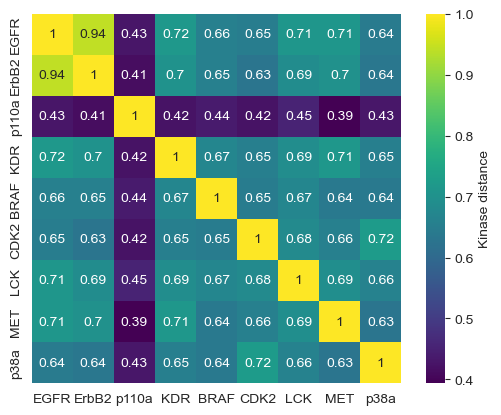

In [15]:
sns.heatmap(
    1 - kinase_distance_matrix,
    linewidths=0,
    annot=True,
    square=True,
    cbar_kws={"label": "Kinase distance"},
    cmap="viridis",
)
plt.show()

#### Visualize similarity as dendrogram

Since distance matrices are symmetric, we use the `scipy` function `squareform` to create a condensed vector of the distance matrix of shape $n*(n-1)/2$, where $n$ is the shape of the distance matrix. The values in this vector correspond to the values of the lower triangular matrix.

In [16]:
D = kinase_distance_matrix.values
D_condensed = distance.squareform(D)
D_condensed

array([0.059037, 0.572938, 0.283953, 0.344972, 0.351553, 0.288679,
       0.288742, 0.355356, 0.586362, 0.297882, 0.3454  , 0.369692,
       0.314925, 0.302033, 0.364827, 0.577295, 0.563541, 0.576006,
       0.548664, 0.606301, 0.568806, 0.328732, 0.346621, 0.312352,
       0.286194, 0.346556, 0.353245, 0.327067, 0.361842, 0.362088,
       0.318747, 0.343975, 0.276907, 0.309121, 0.337419, 0.370645])

We can submit this condensed vector to a hierarchical clustering to extract the relationship between the different kinases. We use here `method="average"`, which stands for the linkage method UPGMA (unweighted pair group method with arithmetic mean). This means that the distance between two clusters A and B is defined as the average of all distances between pairs of elements in clusters A and B. At each clustering step, the two clusters with the lowest average distance are combined.

In [17]:
hclust = hierarchy.linkage(D_condensed, method="average")

We now generate a phylogenetic tree based on the clustering.

In [18]:
tree = hierarchy.to_tree(hclust)

We visualize the tree as a dendrogram.

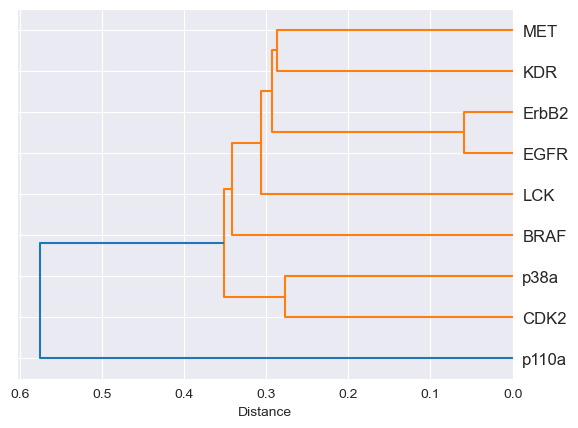

In [19]:
fig, ax = plt.subplots()
labels = kinase_distance_matrix.columns.to_list()
hierarchy.dendrogram(hclust, labels=labels, orientation="left", ax=ax)
ax.set_xlabel("Distance")
plt.show()

### Visualize similarities from the four different perspectives

#### Preprocess distance matrices

##### Normalize matrices 

We normalize the different matrices to values in $[0, 1]$.

In [20]:
def _min_max_normalize(distance_matrix_df):
    """
    Apply min-max normalization to input DataFrame.

    Parameters
    ----------
    kinase_distance_matrix_df : pd.DataFrame
        Kinase distance matrix.

    Returns
    -------
    pd.DataFrame
        Normalized kinase distance matrix.
    """
    min_ = distance_matrix_df.min().min()
    max_ = distance_matrix_df.max().max()
    distance_matrix_normalized_df = (distance_matrix_df - min_) / (max_ - min_)
    return distance_matrix_normalized_df

In [21]:
kinase_distance_matrices_normalized = {}
for descriptor, score_df in kinase_distance_matrices.items():
    score_normalized_df = _min_max_normalize(score_df)
    kinase_distance_matrices_normalized[descriptor] = score_normalized_df

##### Define kinase order

Define in which order to display the kinases.

In [22]:
kinase_names = kinase_distance_matrices_normalized["sequence"].columns

In [23]:
def _define_kinase_order(kinase_distance_matrix_df, kinase_names, label=""):
    """
    Define the order in which kinases shall
    appear in the input DataFrame.

    Parameters
    ----------
    kinase_distance_matrix_df : pd.DataFrame
        Kinase distance matrix.
    kinase_name : list of str
        List of kinase names to be used for sorting.
    label : str
        Add label for the input matrix.

    Returns
    -------
    pd.DataFrame
        Kinase distance matrix with sorted columns/rows.
    """
    # Remove kinases from ordered kinase set that are not
    # present in input kinase matrix
    kinase_names = [name for name in kinase_names if name in kinase_distance_matrix_df.columns]
    print(f"Kinases present in {label} kinase matrix:\n {kinase_names}")
    # Reorder kinases in matrix
    kinase_distance_matrix_df = kinase_distance_matrix_df.reindex(kinase_names, axis=1).reindex(
        kinase_names, axis=0
    )
    return kinase_distance_matrix_df

In [24]:
kinase_distance_matrices_normalized = {
    descriptor: _define_kinase_order(score_df, kinase_names, descriptor)
    for descriptor, score_df in kinase_distance_matrices_normalized.items()
}

Kinases present in sequence kinase matrix:
 ['EGFR', 'ErbB2', 'p110a', 'KDR', 'BRAF', 'CDK2', 'LCK', 'MET', 'p38a']
Kinases present in kissim kinase matrix:
 ['EGFR', 'ErbB2', 'p110a', 'KDR', 'BRAF', 'CDK2', 'LCK', 'MET', 'p38a']
Kinases present in ifp kinase matrix:
 ['EGFR', 'ErbB2', 'p110a', 'KDR', 'BRAF', 'CDK2', 'LCK', 'MET', 'p38a']
Kinases present in ligand-profile kinase matrix:
 ['EGFR', 'ErbB2', 'p110a', 'KDR', 'BRAF', 'CDK2', 'LCK', 'MET', 'p38a']


#### Visualize kinase similarities

In [25]:
def heatmap(score_df, ax=None, title=""):
    """
    Generate a heatmap from a matrix.

    Parameters
    ----------
    score_df : pd.DataFrame
        Distance or similarity score matrix.
    ax : matplotlib.axes
        Plot axis to use!
    title : str
        Plot title.
    """
    sns.heatmap(score_df, linewidths=0, annot=True, square=True, cmap="viridis", ax=ax)

In [26]:
def dendrogram(distance_matrix, ax=None, title=""):
    """
    Generate a dendrogram from a distance matrix.

    Parameters
    ----------
    distance_matrix : pd.DataFrame
        Distance matrix.
    ax : matplotlib.axes
        Plot axis to use!
    title : str
        Plot title.
    """
    D = distance_matrix.values
    D_condensed = distance.squareform(D)
    hclust = hierarchy.linkage(D_condensed, method="average")
    tree = hierarchy.to_tree(hclust)
    labels = distance_matrix.columns.to_list()
    hierarchy.dendrogram(hclust, labels=labels, orientation="left", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Distance")

Note for ease of interpretability, we show below:

* Heatmaps based on the **similarity** matrix (the higher the value, the higher the similarity).
* Dendrograms calculated based on the **distance** matrix, where clusters describe the similarity between kinases.

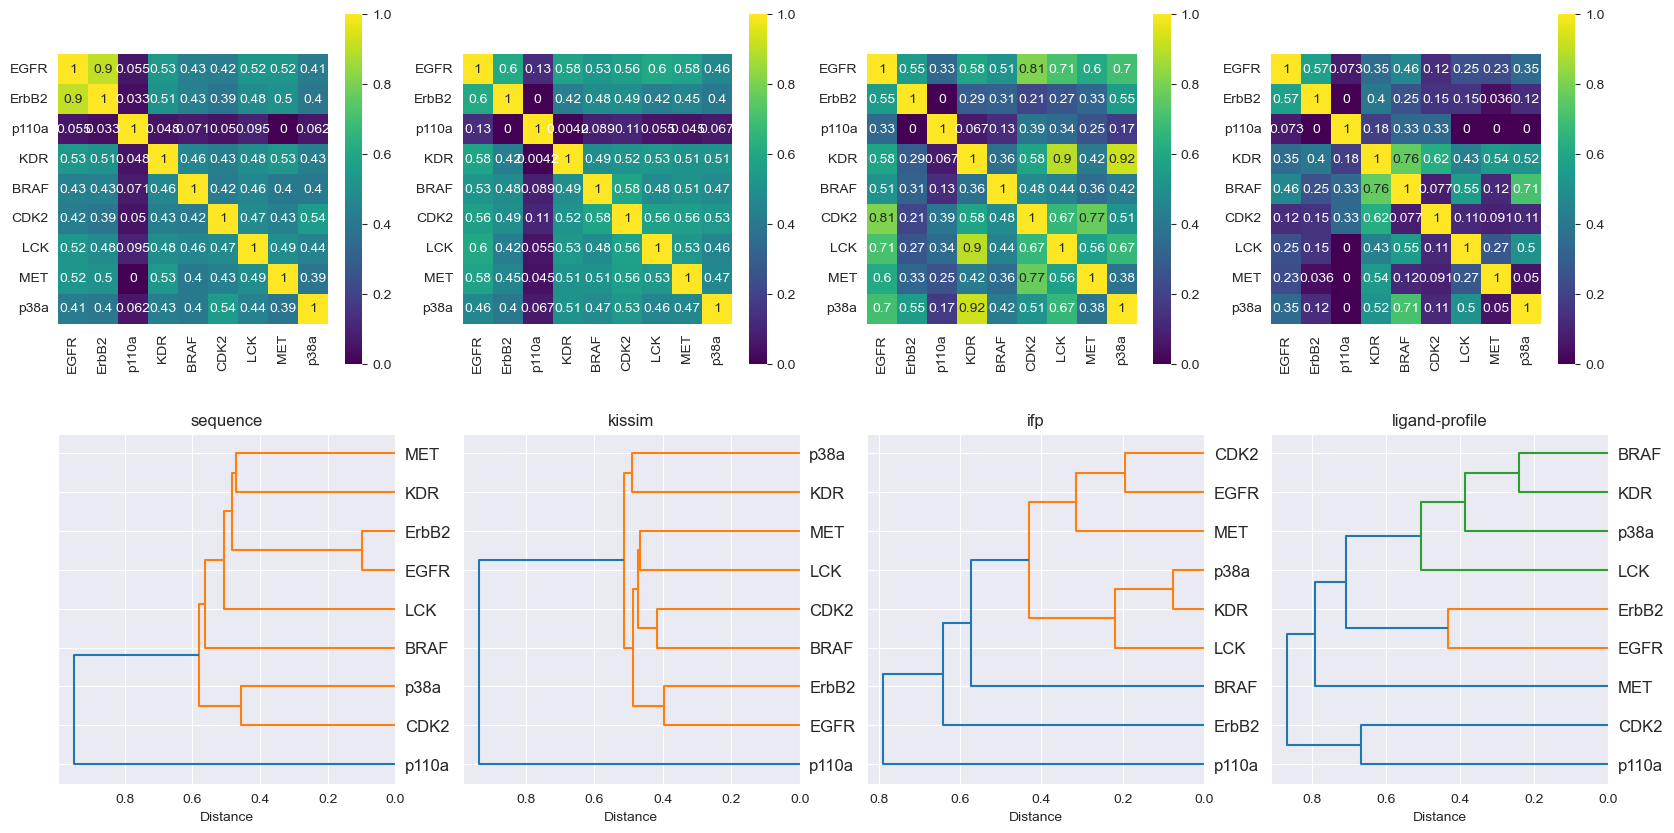

In [27]:
n_perspectives = len(kinase_distance_matrices_normalized)
fig, axes = plt.subplots(2, n_perspectives, figsize=(n_perspectives * 5, 10))
for i, (perspective, distance_matrix) in enumerate(kinase_distance_matrices_normalized.items()):
    # heatmap based on similarity matrix
    similarity_matrix = 1 - distance_matrix
    heatmap(similarity_matrix, ax=axes[0][i], title=perspective)
    # dendrogram based on distance matrix
    dendrogram(distance_matrix, ax=axes[1][i], title=perspective)

We load here again the input kinase information that we defined in __Talktorial T023__, to determine, among other, to which group each kinase belongs to.

In [28]:
kinase_selection_df = pd.read_csv(HERE / "../T023_what_is_a_kinase/data/kinase_selection.csv")
kinase_selection_df

,kinase,kinase_klifs,uniprot_id,group,full_kinase_name
0,EGFR,EGFR,P00533,TK,Epidermal growth factor receptor
1,ErbB2,ErbB2,P04626,TK,Erythroblastic leukemia viral oncogene homolog 2
2,PI3K,p110a,P42336,Atypical,Phosphatidylinositol-3-kinase
3,VEGFR2,KDR,P35968,TK,Vascular endothelial growth factor receptor 2
4,BRAF,BRAF,P15056,TKL,Rapidly accelerated fibrosarcoma isoform B
5,CDK2,CDK2,P24941,CMGC,Cyclic-dependent kinase 2
6,LCK,LCK,P06239,TK,Lymphocyte-specific protein tyrosine kinase
7,MET,MET,P08581,TK,Mesenchymal-epithelial transition factor
8,p38a,p38a,Q16539,CMGC,p38 mitogen activated protein kinase alpha


#### Analysis of results

- The _sequence_ approach reproduces nicely the Manning tree relationships.
  - The TK kinases EGFR, ErbB2, MET, and KDR are grouped together with highest similarities for EGFR and ErbB2.
  - The TKL kinase LCK groups next to the TK kinases.
  - The CMGC kinases p38a and CDK2 are grouped together.
  - The atypical kinase p110a is a singleton, i.e., forms its own cluster.
- When taking into account the pocket structure (physicochemical and spatial properties) with the _kissim_ approach, similar observations can be made: 
  - The typical kinases are grouped together, while the atypical kinase p110a is a singleton. 
  - Within the typical kinase grouping, EGFR and ErbB2 are the most similar (but not as prominent as in the _sequence_ approach).
  - Kinases from different groups, e.g. CDK2 (CMGC) and BRAF (TKL), cluster together.
- The _ifp_ method:
  - BRAF and the atypical kinase p110a form a singleton each.
  - Surprisingly, ErbB2 forms a singleton (=not grouped with EGFR), but we have to keep in mind that we have the least data points ($4$) for ErbB2.
- The _ligand-profile_ method:
  - Interestingly, CDK2 and p110a form their own cluster early on (i.e. low similarity to the rest).
  - BRAF (TKL), p38a (CMGC), KDR and LCK (both TK) as well as EGFR and ErbB2 (TK) form one cluster each.
  - Surprisingly, MET (TK) forms a singleton (not clustering with any of the other TK kinases).
- Overall observations:
  - Members of the same family (here: EGFR and ErbB2) are grouped together closely in the _sequence_, _kissim_, and _ligand-profile_ approaches.
  - The atypical kinase p110a shows high dissimilarity in the _sequence_, _kissim_, and _ifp_ approaches.
  - Unexpectedly, KDR (TK) and p38a (CMGC) cluster together in all views (except for _sequence_). Thus, it would be interesting to explore this relationship further.

<!---
- Comparison to multi-target profiles in [<i>Molecules</i> (2021), <b>26(3)</b>, 629](https://www.mdpi.com/1420-3049/26/3/629)
  - Profile 1: 
    - EGFR/ErbB2 as on-targets and BRAF as anti-target
    - Should be doable from "sequence", "ligand-profile" view (less clear from "kisim" and "ifp" view)
  - Profile 2:
    - EGFR/p110a as on-targets and BRAF as anti-target
    - Should be hard to design from all views
  - Profile 3: 
    - EGFR/KDR as on-targets and BRAF as anti-target
    - Should be hard to design except from a "sequence" view
--->

## Discussion

We have assessed kinase similarity from many different angles: the pocket sequence, the pocket structure, ligand binding modes (interaction fingerprints), and ligand bioactivities. We see from our results that different conclusions can be drawn for each method, while some observations agree.
Thus, it is beneficial to consider different strategies to study kinase similarity.

The different approaches have strengths and drawbacks:

- The _sequence_ method: Sequence data is available for all kinases, however no information about structure or ligand binding is included.
- The _kissim_, _ifp_, and _ligand-profile_ methods: Information about structure, ligand binding, or ligand bioactivity is included, however some kinases may not have any data, some kinases may have only few data, and most kinases may not be fully explored (even if a lot of data is available).
- All methods rely on simplifications! 
  - Dealing with multiple measurements
    - _ligand-profile_ method: Only one measurement per kinase-ligand is used here.
    - _kissim_ and _ifp_ method: Only one structure/IFP pair represents one kinase pair here.
  - Bioactivity cutoffs to define active/inactive compounds in case of the _ligand-profile_ method.

## Quiz

1. Can you think of another perspective to assess kinase similarity?
2. Are there other methods to assess and visualize the similarities?
3. Can you name at least one advantage and one disadvantage per perspective discussed here?
4. Could the different methods be applied to other proteins in general?
5. What is the difference between the distances that we show in the heatmap and the dendrogram? 
6. Rerun the notebooks T023-T028 on another kinase dataset. 
   1. If you need inspiration, you can use the kinases used by [Xiong et al.](https://doi.org/10.1371/journal.pcbi.1009302) to predict multi-targeting compounds for RET-driven cancers (see Table 1): RET, BRAF, SRC, RPS6KB1, MKNK1, TTK, PDK1, and PAK3 (notes: We are omitting ERK8 since this kinase has no structures; RPS6KB1 is listed as S6K in Table 1.). Update the `T023_what_is_a_kinase/data/kinase_selection.csv` file yourself with the mandatory columns `kinase_klifs` and `uniprot_id` (or copy-paste the data from `T023_what_is_a_kinase/data/kinase_selection_xiong.csv`).
   2. Update the configuration file `T023_what_is_a_kinase/data/pipeline_configs.csv` as follows: `DEMO=0`, `N_STRUCTURES_PER_KINASE=2` (the more structures used, the longer T025 will take), and `N_CORES` as your system allows.

## Appendix

In this appendix, we generate individual plots (both heatmap and dendrogram) for the sequence perspective. The plots are saved in svg format.

#### Sequence heatmap in svg

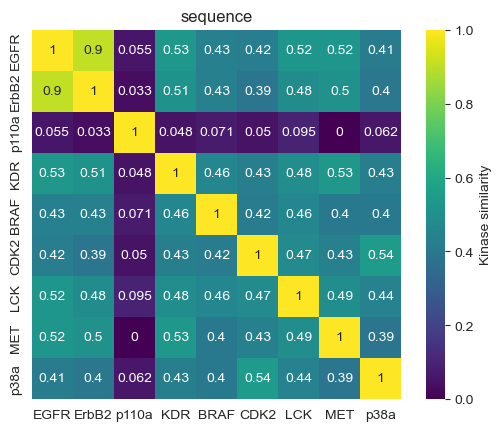

In [29]:
fig, ax = plt.subplots()
sns.heatmap(
    1 - kinase_distance_matrices_normalized["sequence"],
    linewidths=0,
    annot=True,
    square=True,
    cbar_kws={"label": "Kinase similarity"},
    cmap="viridis",
)
plt.title("sequence")
plt.savefig(DATA / "heatmap_sequence.svg")

#### Sequence dendrogram in svg

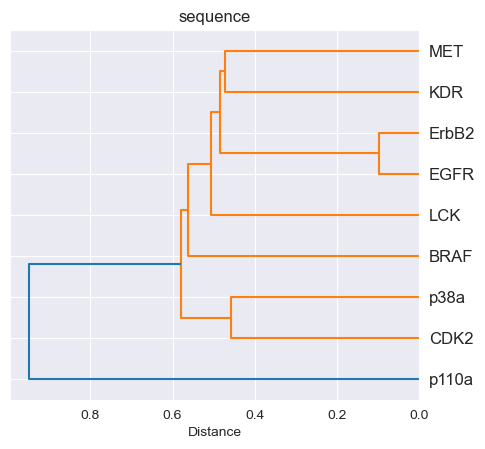

In [30]:
fig, ax = plt.subplots()
D = kinase_distance_matrices_normalized["sequence"].values
D_condensed = distance.squareform(D)
hclust = hierarchy.linkage(D_condensed, method="average")
tree = hierarchy.to_tree(hclust)
labels = distance_matrix.columns.to_list()
hierarchy.dendrogram(hclust, labels=labels, orientation="left", ax=ax)
ax.set_title("sequence")
ax.set_xlabel("Distance")
ax.set_aspect(1 / 100)
plt.savefig(DATA / "dendrogram_sequence.svg")

### One single measure of comparison

Instead of having four different measures of similarity, we compute a equally weighted average to obtain one single similarity matrix (and associated heatmap), and one single distance matrix (and associated dendrogram).

Weighting differently the various perspectives could be further investigated.

In [31]:
combined_distance_matrix = (
    sum([distance_matrix for distance_matrix in kinase_distance_matrices_normalized.values()])
    / n_perspectives
)
combined_distance_matrix

,EGFR,ErbB2,p110a,KDR,BRAF,CDK2,LCK,MET,p38a
EGFR,0.000000,0.345073,0.853070,0.488292,0.517561,0.522226,0.480177,0.517406,0.520092
ErbB2,0.345073,0.000000,0.991778,0.595015,0.631776,0.690813,0.670081,0.669546,0.631571
p110a,0.853070,0.991778,0.000000,0.924348,0.845578,0.779110,0.876636,0.926215,0.925134
KDR,0.488292,0.595015,0.924348,0.000000,0.482481,0.463151,0.412795,0.502286,0.405543
BRAF,0.517561,0.631776,0.845578,0.482481,0.000000,0.611584,0.518079,0.654472,0.499924
CDK2,0.522226,0.690813,0.779110,0.463151,0.611584,0.000000,0.545841,0.538301,0.575915
LCK,0.480177,0.670081,0.876636,0.412795,0.518079,0.545841,0.000000,0.535791,0.483474
MET,0.517406,0.669546,0.926215,0.502286,0.654472,0.538301,0.535791,0.000000,0.677882
p38a,0.520092,0.631571,0.925134,0.405543,0.499924,0.575915,0.483474,0.677882,0.000000


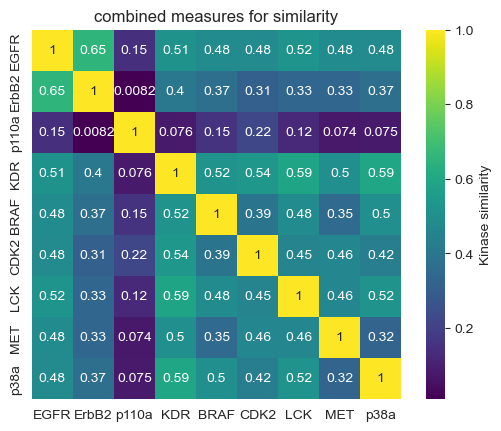

In [32]:
fig, ax = plt.subplots()
sns.heatmap(
    1 - combined_distance_matrix,
    linewidths=0,
    annot=True,
    square=True,
    cbar_kws={"label": "Kinase similarity"},
    cmap="viridis",
)
plt.title("combined measures for similarity")
plt.show()

In [33]:
# In case one or more perspectives have missing kinases,
# the combined distance matrix will contain NaN values
# Remove the missing kinases (and NaN values) from the matrix
# before plotting the dendrogram
combined_distance_matrix = combined_distance_matrix.dropna(axis=0, how="all").dropna(
    axis=1, how="all"
)
combined_distance_matrix

,EGFR,ErbB2,p110a,KDR,BRAF,CDK2,LCK,MET,p38a
EGFR,0.000000,0.345073,0.853070,0.488292,0.517561,0.522226,0.480177,0.517406,0.520092
ErbB2,0.345073,0.000000,0.991778,0.595015,0.631776,0.690813,0.670081,0.669546,0.631571
p110a,0.853070,0.991778,0.000000,0.924348,0.845578,0.779110,0.876636,0.926215,0.925134
KDR,0.488292,0.595015,0.924348,0.000000,0.482481,0.463151,0.412795,0.502286,0.405543
BRAF,0.517561,0.631776,0.845578,0.482481,0.000000,0.611584,0.518079,0.654472,0.499924
CDK2,0.522226,0.690813,0.779110,0.463151,0.611584,0.000000,0.545841,0.538301,0.575915
LCK,0.480177,0.670081,0.876636,0.412795,0.518079,0.545841,0.000000,0.535791,0.483474
MET,0.517406,0.669546,0.926215,0.502286,0.654472,0.538301,0.535791,0.000000,0.677882
p38a,0.520092,0.631571,0.925134,0.405543,0.499924,0.575915,0.483474,0.677882,0.000000


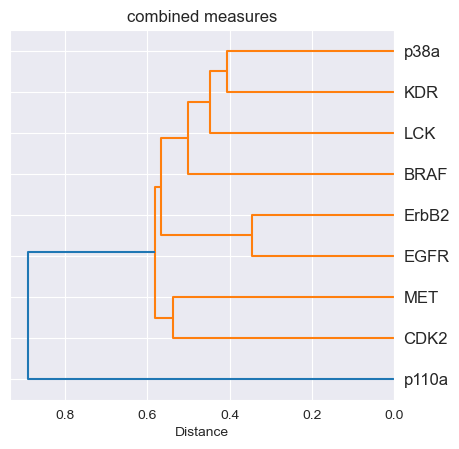

In [34]:
fig, ax = plt.subplots()
D = combined_distance_matrix
D_condensed = distance.squareform(D)
hclust = hierarchy.linkage(D_condensed, method="average")
tree = hierarchy.to_tree(hclust)
labels = combined_distance_matrix.columns.to_list()
hierarchy.dendrogram(hclust, labels=labels, orientation="left", ax=ax)
ax.set_title("combined measures")
ax.set_xlabel("Distance")
ax.set_aspect(1 / 100)